# Stochastic Hurricane Model - Markov processes and Monte Carlo

This jupyter notebook is to lay out how I made a statistical hurricane track model using synthetic STORM-IBTrACS data from the Royal Dutch Meteorological Institute (KNMI). Conventionally markov processes have been somewhat poorly suited to modelling hurricanes due to our short dataset of historical storms, hindering reliability. Synthetic data allows use to have access to huge volumes of data that make data-heavy techniques like markov processes possible/more accessible... pretty cool! This project can then be interpreted as a **very** preliminary investigation to how models made with this synthetic data are able to predict real events. 

In [ ]:
# relevant packages used
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy import geodesic
import xarray as xr
from concurrent.futures import ProcessPoolExecutor
from math import radians, sin, cos, sqrt, atan2

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

## STORM IBTrACS data
Datasets consisting of 10,000 years of synthetic tropical cyclone tracks, generated using the Synthetic Tropical cyclOne geneRation Model (STORM) algorithm (see Bloemendaal et al, Generation of a Global Synthetic Tropical cyclone Hazard Dataset using STORM, in review). The dataset is generated using historical data from IBTrACS and resembles present-climate conditions. The data can be used to calculate tropical cyclone risk in all (coastal) regions prone to tropical cyclones.

Bloemendaal, Nadia; Haigh, I.D. (Ivan); de Moel, H. (Hans); Muis, S; Haarsma, R.J. (Reindert) et. al. (2022): STORM IBTrACS present climate synthetic tropical cyclone tracks. Version 4. 4TU.ResearchData. dataset. https://doi.org/10.4121/12706085.v4

In [ ]:
def load_storm_ibtracs(file_path):
    """
    Load STORM_IBTrACS synthetic hurricane track data from a .txt file.

    Parameters:
        file_path (str): Path to the .txt file.

    Returns:
        pd.DataFrame: Preprocessed storm track data with datetime and storm ID.
    """
    col_names = [
        "year", "month", "tc_number", "timestep", "basin_id",
        "lat", "lon", "min_pressure", "max_wind_speed", "r_max",
        "category", "landfall", "distance_to_land"
    ]
    
    df = pd.read_csv(file_path, header=None, names=col_names)
    
    # Create a synthetic datetime (assuming 3-hourly timesteps)
    df["time_since_start"] =  pd.to_timedelta(df["timestep"] * 3, unit="h")
    
    # Create a unique storm ID
    df["storm_id"] = "idx_" + file_path[-5] + "_year_" + df["year"].astype(str) + "_number_" + df["tc_number"].astype(str)
    
    # Reorder and return
    return df[["storm_id", "lat", "lon", "time_since_start", "basin_id", "min_pressure", "max_wind_speed"]]

def load_all_north_atlantic_storms():
    """
    Load and concatenate all 10 North Atlantic STORM_IBTrACS text files
    from the VERSIE4 folder into a single DataFrame. 

    Returns:
        pd.DataFrame: Combined storm track data for 10,000 years.
    """
    data_dir = os.path.join(project_root, "Data", "STORM_IBTraCS_data", "VERSIE4")
    all_data = []

    for i in range(10):
        filename = f"STORM_DATA_IBTRACS_NA_1000_YEARS_{i}.txt"
        file_path = os.path.join(data_dir, filename)
        if os.path.exists(file_path):
            df = load_storm_ibtracs(file_path)
            all_data.append(df)
        else:
            print(f"Warning: File not found - {file_path}")

    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

In [22]:
north_atlantic_data = load_all_north_atlantic_storms()
print(f"Loaded {len(north_atlantic_data)} storm track records.")
north_atlantic_data

Loaded 3424299 storm track records.


,storm_id,lat,lon,time_since_start,basin_id,min_pressure,max_wind_speed
0,idx_0_year_0.0_number_0.0,8.9,314.8,0 days 00:00:00,1.0,993.946699,20.371998
1,idx_0_year_0.0_number_0.0,9.0,314.3,0 days 03:00:00,1.0,992.800000,21.200000
2,idx_0_year_0.0_number_0.0,9.1,313.6,0 days 06:00:00,1.0,992.100000,21.700000
3,idx_0_year_0.0_number_0.0,9.2,312.7,0 days 09:00:00,1.0,993.000000,21.100000
4,idx_0_year_0.0_number_0.0,9.3,311.7,0 days 12:00:00,1.0,993.100000,20.900000
...,...,...,...,...,...,...,...
3424294,idx_9_year_999.0_number_16.0,33.3,280.3,10 days 18:00:00,1.0,976.100000,34.000000
3424295,idx_9_year_999.0_number_16.0,33.7,279.8,10 days 21:00:00,1.0,976.100000,33.964694
3424296,idx_9_year_999.0_number_16.0,34.1,279.4,11 days 00:00:00,1.0,985.900000,27.511566
3424297,idx_9_year_999.0_number_16.0,34.5,278.9,11 days 03:00:00,1.0,993.300000,22.343949


### Building the Transition Matrix for Hurricane Tracks

This function takes the sythetic hurricane track data and converts it into a **transition matrix**, which describes the probability of a storm moving from one grid cell to another. Essentially acting like a roadmap of probabilities, letting us determine: if we start at a point x, where are we **likely** to go for the next step. The chain connecting each step to the next is the markov chain. Our plan: generate these reliably from the data

#### Discretize the tracks
The latitude and longitude of each storm position are mapped onto a regular grid. For example, with a resolution of 0.25° (chosed because it aligns with the resolution of ERA5, will ease the headache of developing the model further in the future), the continuous positions are snapped to the nearest grid cells. Each position is then labeled by its grid cell ID. 

Then for each storm, we look at the sequence of grid cells it passed through. From this sequence, we record all the "hops" between consecutive cells.  
Example: if a storm path visits cells **A → B → C**, we record two transitions: **A→B** and **B→C**.

#### Count how often transitions occur and convert to probabilities
We count the number of times each transition happens across all storms. For example: from cell **A** to cell **B** happened 10 times and from cell **A** to cell **C** happened 5 times.

Then for each starting cell, we divide by the total number of transitions leaving that cell. This gives us the probability of moving from one cell to another. For instance:
- From **A**, the probability to go to **B** = 10 / (10+5) = 0.67  
- From **A**, the probability to go to **C** = 5 / (10+5) = 0.33

#### Transition matrix
All of these probabilities are stored in a square matrix, where:
- Rows = current cell
- Columns = next cell
- Each row sums to 1 (since it represents all possible next steps)

P =
\begin{bmatrix}
P(A \rightarrow A) & P(A \rightarrow B) & P(A \rightarrow C) \\
P(B \rightarrow A) & P(B \rightarrow B) & P(B \rightarrow C) \\
P(C \rightarrow A) & P(C \rightarrow B) & P(C \rightarrow C) \\
\end{bmatrix}


This matrix is the foundation of a **Markov model** that can simulate realistic storm tracks by probabilistically stepping through the grid.


In [ ]:
def build_transition_matrix(df, lat_resolution=0.25, lon_resolution=0.25):
    """
    Build a transition matrix from storm track data by discretizing lat/lon into grid cells.

    Parameters:
        df (pd.DataFrame): Storm track data with "storm_id", "lat", "lon", and "time_since_start".
        lat_resolution (float): Grid resolution in degrees for latitude.
        lon_resolution (float): Grid resolution in degrees for longitude.

    Returns:
        transition_matrix (pd.DataFrame): Transition probabilities between grid cells.
        grid_index_map (dict): Mapping from grid cell (lat_idx, lon_idx) to matrix index.
    """
    # Discretize lat/lon into grid indices
    df["lat_idx"] = np.floor(df["lat"] / lat_resolution).astype(int)
    df["lon_idx"] = np.floor(df["lon"] / lon_resolution).astype(int)

    # Create a unique grid cell ID
    df["grid_cell"] = list(zip(df["lat_idx"], df["lon_idx"]))

    # Sort by storm_id and time
    df_sorted = df.sort_values(by=["storm_id", "time_since_start"])

    # Extract transitions
    transitions = []
    for storm_id, group in df_sorted.groupby("storm_id"):
        cells = group["grid_cell"].tolist()
        transitions += list(zip(cells[:-1], cells[1:]))

    # Count transitions
    transition_counts = {}
    for from_cell, to_cell in transitions:
        if from_cell not in transition_counts:
            transition_counts[from_cell] = {}
        if to_cell not in transition_counts[from_cell]:
            transition_counts[from_cell][to_cell] = 0
        transition_counts[from_cell][to_cell] += 1

    # Build index mapping
    unique_cells = set([cell for pair in transitions for cell in pair])
    grid_index_map = {cell: idx for idx, cell in enumerate(sorted(unique_cells))}

    # Initialize transition matrix
    n = len(grid_index_map)
    matrix = np.zeros((n, n))

    # Fill matrix with transition probabilities
    for from_cell, to_dict in transition_counts.items():
        from_idx = grid_index_map[from_cell]
        total = sum(to_dict.values())
        for to_cell, count in to_dict.items():
            to_idx = grid_index_map[to_cell]
            matrix[from_idx, to_idx] = count / total

    # Convert to DataFrame for readability
    transition_matrix = pd.DataFrame(matrix, index=grid_index_map.keys(), columns=grid_index_map.keys())

    return transition_matrix, grid_index_map

In [7]:
transition_matrix, grid_index_map = build_transition_matrix(north_atlantic_data, lat_resolution=0.25, lon_resolution=0.25)
print("Transition matrix shape:", transition_matrix.shape)
print(grid_index_map)

Transition matrix shape: (68341, 68341)
{(20, 1203): 0, (20, 1256): 1, (20, 1258): 2, (20, 1261): 3, (20, 1263): 4, (20, 1265): 5, (20, 1267): 6, (20, 1270): 7, (20, 1272): 8, (20, 1274): 9, (20, 1277): 10, (20, 1279): 11, (20, 1280): 12, (20, 1281): 13, (20, 1282): 14, (20, 1283): 15, (20, 1284): 16, (20, 1285): 17, (20, 1286): 18, (20, 1287): 19, (20, 1288): 20, (20, 1289): 21, (20, 1290): 22, (20, 1291): 23, (20, 1292): 24, (20, 1293): 25, (20, 1294): 26, (20, 1295): 27, (20, 1296): 28, (20, 1297): 29, (20, 1298): 30, (20, 1299): 31, (20, 1300): 32, (20, 1301): 33, (20, 1302): 34, (20, 1303): 35, (20, 1304): 36, (20, 1305): 37, (20, 1306): 38, (20, 1307): 39, (20, 1308): 40, (20, 1310): 41, (20, 1318): 42, (20, 1320): 43, (20, 1322): 44, (20, 1324): 45, (20, 1326): 46, (20, 1328): 47, (21, 1206): 48, (21, 1243): 49, (21, 1244): 50, (21, 1248): 51, (21, 1251): 52, (21, 1254): 53, (21, 1255): 54, (21, 1258): 55, (21, 1261): 56, (21, 1264): 57, (21, 1266): 58, (21, 1269): 59, (21, 1271

In [8]:
def simulate_storm_track(transition_matrix, grid_index_map, start_location, steps=50):
    """
    Simulate a storm track using a Markov process based on the transition matrix.

    Parameters:
        transition_matrix (pd.DataFrame): Square matrix of transition probabilities.
        grid_index_map (dict): Mapping from grid cell (lat, lon) to matrix index.
        steps (int): Number of steps to simulate.

    Returns:
        list: Sequence of (lat, lon) grid cells representing the storm track.
    """
    def coordinate_to_grid_cell(lat, lon, lat_res=0.25, lon_res=0.25, lon_offset=0):
        if lon_offset == 360 and lon < 0:
            lon += 360

        lat_idx = np.floor(lat / lat_res).astype(int)
        lon_idx = np.floor(lon / lon_res).astype(int)
        return (lat_idx, lon_idx)

    # Reverse the grid_index_map to get index -> (lat, lon)
    index_to_grid = {v: k for k, v in grid_index_map.items()}

    # Start from a random grid cell
    current_index = grid_index_map[coordinate_to_grid_cell(start_location[0], start_location[1])]
    track = [index_to_grid[current_index]]

    for _ in range(steps):
        # Get the transition probabilities from the current state
        probs = transition_matrix.iloc[current_index].values

        # If all probabilities are zero, stop the simulation
        if probs.sum() == 0:
            break

        # Normalize probabilities in case of rounding issues
        probs = probs / probs.sum()

        # Choose the next state based on the transition probabilities
        next_index = np.random.choice(len(probs), p=probs)
        track.append(index_to_grid[next_index])
        current_index = next_index

    return track

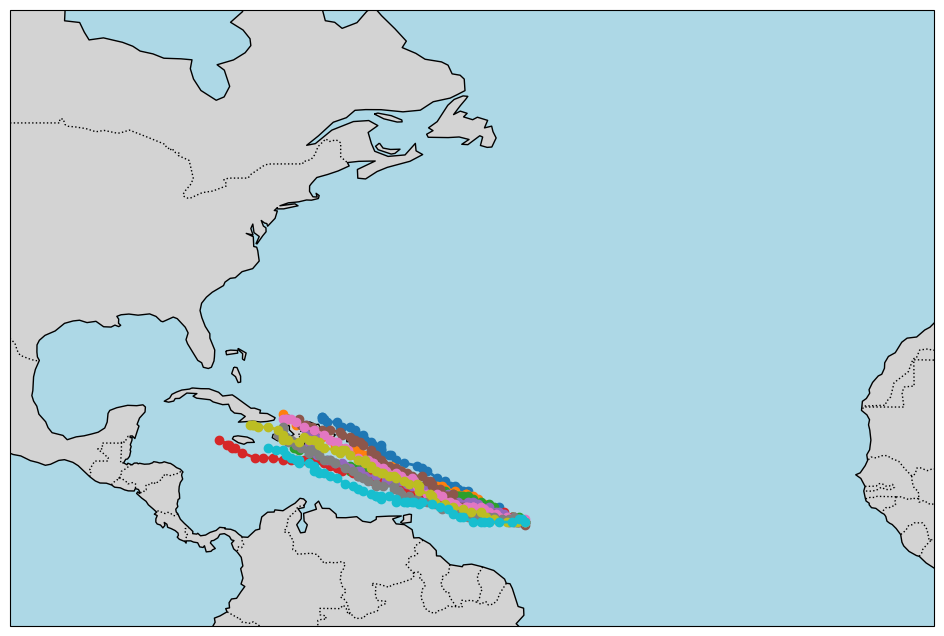

In [ ]:
def gridcell_to_latlon(lat_idx, lon_idx, lat_res=0.25, lon_res=0.25):
    lat = (lat_idx + 0.5) * lat_res
    lon = (lon_idx + 0.5) * lon_res
    return (lat, lon)

tracks = []
for _ in range(10):
    track_indices = simulate_storm_track(transition_matrix, grid_index_map, start_location=(10,310), steps=50)
    track_coords = [gridcell_to_latlon(lat_idx, lon_idx) for (lat_idx, lon_idx) in track_indices]
    tracks.append(track_coords)

# Plot the grid cells on a Cartopy map
plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-100, -10, 0, 60], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

# Plot each grid cell as a point
for i in range(len(tracks)):
    storm_lats, storm_lons = zip(*tracks[i])
    ax.plot(storm_lons, storm_lats, color="C"+str(i), linewidth=2, marker="o", transform=ccrs.PlateCarree())

plt.show()

### Monte Carlo Simulation of Storm Tracks

Now we can generate Markov Chains that represent how a hurricane might move through the grid map (the north atlantic basin), but this doesn't really tell us that much. Its just one realization, or observation. We can't do statistics with this. Monte Carlo, essentially running **many** simulations, lets us then take the average track, find the confidence intervals, and have a more robust model. 

#### Run many simulations (padding tracks to equal length)
We start from the same initial storm location, then simulate storm tracks by stepping through the transition matrix. Each track is slightly different, since the next step is chosen randomly according to the transition probabilities.

- Repeat this process `n_tracks` times (for example, 1000 times).
- Each run produces one possible storm path.

Storms may naturally "end" at different times (some dissipate earlier). To compare them fairly:
- We pad shorter tracks with `(NaN, NaN)` values so that all tracks have the same number of steps.  
- This ensures we can store them in a single array and compute statistics across simulations.

#### Organize into arrays
The collection of simulated tracks is stored in a 3D array:
- Dimension 1 = track number  
- Dimension 2 = time step  
- Dimension 3 = coordinates (latitude, longitude)  

So you can easily slice and analyze the ensemble of simulations.

#### Compute ensemble statistics
From this collection of tracks, we can compute summary statistics such as:
- **Mean track**: the average latitude and longitude at each time step across all simulations  
- **Spread**: how variable the simulated tracks are (useful for uncertainty estimates)

#### Monte Carlo idea
By simulating a large number of tracks, we approximate the distribution of possible storm paths implied by the transition matrix. The result is not one forecast, but an **ensemble** that captures both the most likely path and the uncertainty around it. We can then apply this approximated distribution to inform our confidence intervals and any other statistics we want to calculate.

In [10]:
def pad_tracks(tracks, length):
    padded = []
    for track in tracks:
        if len(track) < length:
            # Pad with (np.nan, np.nan)
            pad_len = length - len(track)
            track = track + [(np.nan, np.nan)] * pad_len
        padded.append(track)
    return np.array(padded)


def monte_carlo_storms(transition_matrix, grid_index_map, start_location, steps=50, n_tracks=1000):
    tracks, expected_length = [], steps+1
    for _ in range(n_tracks):
        tracks.append(simulate_storm_track(transition_matrix, grid_index_map, start_location, steps))

    tracks = pad_tracks(tracks, expected_length)
    tracks = np.array(tracks)
    lats, lons = tracks[:,:,0], tracks[:,:,1]

    mean_track = [np.nanmean(lats, axis=0), np.nanmean(lons, axis=0)]
    
    return tracks, mean_track

In [18]:
tracks, mean_track = monte_carlo_storms(transition_matrix, grid_index_map, start_location=(10,310), steps=50, n_tracks=1000)
mean_track = list(zip(mean_track[0], mean_track[1]))
np.array(mean_track).shape

(51, 2)

In [12]:
R = 6371 # earth radius in k

def haversine(lat1, lon1, lat2, lon2):
    dlat, dlon = radians(lat2-lat1), radians(lon2-lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

def cone_of_uncertainty(tracks, mean_track):
    n_tracks, n_steps = len(tracks), len(tracks[0])
    distances = np.zeros((n_tracks, n_steps))

    for i in range(n_tracks):
        for j in range(n_steps):
            lat, lon = tracks[i, j]
            mean_lat, mean_lon = mean_track[j]
            if np.isnan(lat) or np.isnan(lon):
                distances[i,j] = np.nan
                continue
            distances[i,j] = haversine(lat, lon, mean_lat, mean_lon)
    
    std_distances = np.nanstd(distances, axis=0)
    conf_inter = 1.96*std_distances
            
    return conf_inter

In [13]:
ci_95 = cone_of_uncertainty(tracks, mean_track)
ci_95

array([   0.        ,  125.11556815,  185.59897027,  228.37819018,
        255.94647177,  282.25077186,  303.20295334,  324.21431847,
        351.35629434,  371.70091296,  387.84229466,  401.43652827,
        406.9404189 ,  419.36068611,  431.16103726,  445.03666161,
        459.32912866,  465.77915721,  481.31327932,  488.36040294,
        506.94201699,  514.45218233,  528.80253623,  535.03037111,
        549.61346871,  565.02755405,  577.78992557,  592.96502431,
        614.93729199,  623.57224813,  638.21162723,  648.27039689,
        659.26362428,  681.36327423,  697.61563385,  719.57979177,
        745.03750346,  768.67861223,  793.15867665,  805.60169658,
        821.09871548,  835.60547744,  854.88908187,  868.00863761,
        879.17484016,  901.7322069 ,  926.87333114,  951.93176776,
        966.06554432,  991.31142609, 1021.25555888])

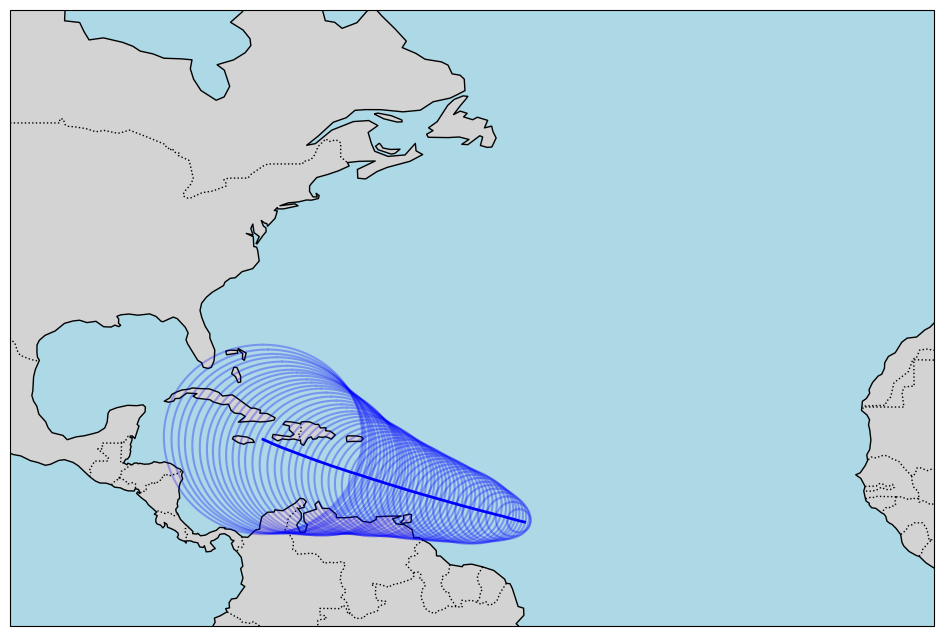

In [ ]:
def gridcell_to_latlon(lat_idx, lon_idx, lat_res=0.25, lon_res=0.25):
    lat = (lat_idx + 0.5) * lat_res
    lon = (lon_idx + 0.5) * lon_res
    return (lat, lon)

mean_latlon = [gridcell_to_latlon(mean_lat_idx, mean_lon_idx) for mean_lat_idx, mean_lon_idx in mean_track]
mean_lat, mean_lon = zip(*mean_latlon)

# Plot the grid cells on a Cartopy map
plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-100, -10, 0, 60], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

# Plot each grid cell as a point
ax.plot(mean_lon, mean_lat, color="blue", linewidth=2, transform=ccrs.PlateCarree())
for (lat, lon), radius_km in zip(mean_latlon, ci_95):
    if np.isnan(radius_km) or np.isnan(lat) or np.isnan(lon):
        continue
    circle = geodesic.Geodesic().circle(lon=lon, lat=lat, radius=radius_km * 1000, n_samples=1000, endpoint=False)
    ax.plot(*zip(*circle), color="blue", alpha=0.3, transform=ccrs.PlateCarree())

plt.show()

### Things are working!
We have a working hurricane track model that generates a cone of uncertainty that is the 95\% confidence interval of the ensemble spread of the model. We can apply this model to forecast storms that really happen, or storms that are developing. We are able to generate a forecasted track of the model from a single point, and require ZERO other information. 

Sounds pretty neat, but unfortuantely this probably means the forecasting power of the storm is likely garbage. But this project is not really intended to replace the national hurricane center, so I think we are good for now. 